In [90]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
import tensorflow_probability as tfp

FFT_WIDTH = 80
input_shape = (FFT_WIDTH,3)

In [91]:
#@keras_export('keras.layers.MultichannelInterpolate')
class MultichannelInterpolate(keras.layers.Layer):
    # TODO: Allow user to specify gaussian windows
    def __init__(self, harmonics):
        super(MultichannelInterpolate, self).__init__(trainable=False)
        self.harmonics = harmonics
        self.built = False

    def build(self, input_shape):
        dummy, self.clefs, self.buckets = input_shape
        super(MultichannelInterpolate, self).build(input_shape)

    def call(self, inputs, **kwargs):
        try:
            assert inputs.shape == (None, self.clefs, self.buckets)
        except:
            print("shape=(%d, %d, %d)" % (self.clefs, self.buckets, self.harmonics) + " inputs.shape=%s" % str(inputs.shape))
            #raise
        #inputs = tf.squeeze(inputs)
        inputs = tf.pad(inputs, tf.constant([[0,0],[0,0],[0,1]]), "CONSTANT") # Add padding to prevent interpolation errors
        inputs = inputs[..., tf.newaxis]                                # and a dummy 3rd dimension, so we can resize it like an image

        from scipy.signal.windows import gaussian
        from scipy.interpolate import interp1d
        import numpy as np

        windows = np.asarray([gaussian(2*self.buckets, 30)[self.buckets:], gaussian(self.buckets, 20), gaussian(2*self.buckets, 30)[:self.buckets]])
        windows = np.transpose(windows)

        output_list = []
        outputs = tf.zeros((self.harmonics,self.buckets), dtype=tf.float32)

        x = np.arange(0,self.buckets+1,1)
        #interpolator = interp1d(x,inputs)

        for h in range(self.harmonics):
            clef_multiplier = tf.constant(windows[h,:], dtype=tf.float32, shape=[1,3])

            interp_factor = 10.0 / (h+1)
            load = tf.image.resize(inputs, [self.clefs,(h+1)*8], method='bilinear', antialias=True, )[...,0]
            #load = interpolator(np.arange(0,80,interp_factor))[:,1:81]
            load = tf.linalg.matmul(clef_multiplier, load)

            try:
                if load.shape[2] < self.buckets:
                    load = tf.pad(load[:,0,:], tf.constant([[0,0],[0,self.buckets-load.shape[2]]]))
                else:
                    load = load[:,0,:self.buckets]
            except:
                print("h=%d, load=%s, clef_multiplier=%s, inputs=%s" % (h, load, clef_multiplier, inputs))
                raise

            output_list.append(load)
                #outputs[h,:len(load)] += load

        output = tf.stack(output_list)
        return tf.reshape(output, [-1, self.harmonics, self.buckets])

    def compute_output_shape(self, input_shape):
        return (self.harmonics, self.buckets)

In [92]:
#calibrations = layers.Input(shape=input_shape)                      # Input is (freq, clef)

calibrations = layers.Input(shape=(3, FFT_WIDTH), name="calibrations")     # Have these fixed for now
norm_calibrations = layers.LayerNormalization(axis=[1,2])(calibrations)
x = MultichannelInterpolate(48)
x1 = x(norm_calibrations)

inputs = layers.Input(shape=(FFT_WIDTH), name="main_input")                       # Input is (freq)
norm_inputs = layers.LayerNormalization(axis=[1])(inputs)

harmonic_extraction = layers.Dot(axes=(2,1))([x1, norm_inputs])                         # Output is (bucket)

input_direct = layers.Dense(96, activation='relu')(norm_inputs)
hidden_layer = layers.Dense(72, activation='relu')(input_direct)
# pool = layers.AveragePooling1D(pool_size = FFT_WIDTH,         # Output is (scaled freq)
#         data_format="channels_first")(x2)

expanded = layers.Reshape((FFT_WIDTH, -1))(norm_inputs)
c1 = layers.Conv1D(6, 5, strides=2, padding='same')(expanded)
c2 = layers.Conv1D(12, 5, strides=2, padding='same')(c1)
c3 = layers.Conv1D(24, 5, strides=2, padding='same')(c2)
c4 = layers.Conv1D(48, 5, strides=2, padding='same')(c3)
pool = layers.MaxPooling1D(5)(c4)
flatten_conv = layers.Flatten()(pool)

merge = layers.Concatenate()([harmonic_extraction, flatten_conv, input_direct])
flat = layers.Flatten()(merge)

out = layers.Dense(48, activation='sigmoid')(hidden_layer)

model = keras.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam")
model.summary()

shape=(3, 80, 48) inputs.shape=(None, 3, 80)
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 80)]              0         
_________________________________________________________________
layer_normalization_47 (Laye (None, 80)                160       
_________________________________________________________________
dense_64 (Dense)             (None, 96)                7776      
_________________________________________________________________
dense_65 (Dense)             (None, 72)                6984      
_________________________________________________________________
dense_66 (Dense)             (None, 48)                3504      
Total params: 18,424
Trainable params: 18,424
Non-trainable params: 0
_________________________________________________________________


In [93]:
import tensorflow as tf
import numpy as np
from math import floor
import random
import os
from sklearn.model_selection import train_test_split

frames_filename = "automated_guitars_inputs.npy"
labels_filename = "automated_guitars_labels.npy"
frames = np.load(frames_filename)
labels = np.load(labels_filename)

assert(labels.shape[0] == frames.shape[0])

# Add other files from other instruments or playstyles
frames = np.concatenate((frames, np.load("automated_guitars_2_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("automated_guitars_2_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("automated_guitars_3_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("automated_guitars_3_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("acoustic_oren_pick_take1_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("acoustic_oren_pick_take1_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("acoustic_oren_thumbpad_take1_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("acoustic_oren_thumbpad_take1_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("acoustic_oren_thumbpad_take2_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("acoustic_oren_thumbpad_take2_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("dane_take1_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("dane_take1_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("silence_pi_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("silence_pi_labels.npy")), axis=0)
frames = np.concatenate((frames, np.load("silence_razer_inputs.npy")), axis=0)
labels = np.concatenate((labels, np.load("silence_razer_labels.npy")), axis=0)

# Shuffle it
data_size = frames.shape[0]
rind = list(range(data_size))
random.shuffle(rind)
frames = np.asarray([frames[i,:,:80] for i in rind])
labels = np.asarray([labels[i,:48] for i in rind])

frames_train, frames_test, labels_train, labels_test = train_test_split(frames, labels, test_size=0.2, random_state=1)
frames_train, frames_val, labels_train, labels_val = train_test_split(frames_train, labels_train, test_size=0.25, random_state=1)

checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(frames_train[:,0,:], labels_train, epochs=100, validation_data=(frames_val[:,0], labels_val), callbacks=[cp_callback])


Epoch 1/100
265/265 [==============================] - 1s 1ms/step - loss: 0.2588 - val_loss: 0.0866

Epoch 00001: saving model to training_1/cp-0001.ckpt
Epoch 2/100
265/265 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0707

Epoch 00002: saving model to training_1/cp-0002.ckpt
Epoch 3/100
265/265 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0649

Epoch 00003: saving model to training_1/cp-0003.ckpt
Epoch 4/100
265/265 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0614

Epoch 00004: saving model to training_1/cp-0004.ckpt
Epoch 5/100
265/265 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0601

Epoch 00005: saving model to training_1/cp-0005.ckpt
Epoch 6/100
265/265 [==============================] - 0s 1ms/step - loss: 0.0532 - val_loss: 0.0582

Epoch 00006: saving model to training_1/cp-0006.ckpt
Epoch 7/100
265/265 [==============================] - 0s 1ms/step - l

Predicted: 0
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


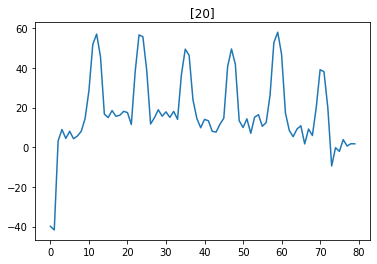

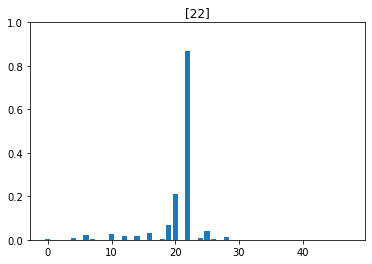

Predicted: 1
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


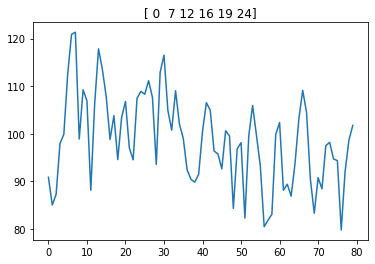

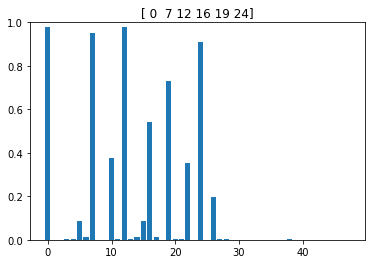

Predicted: 2
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


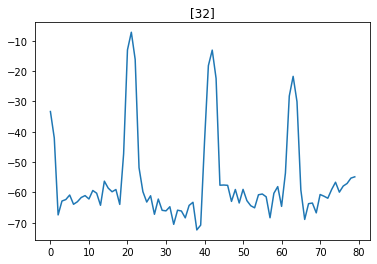

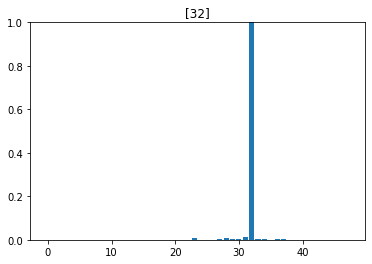

Predicted: 3
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


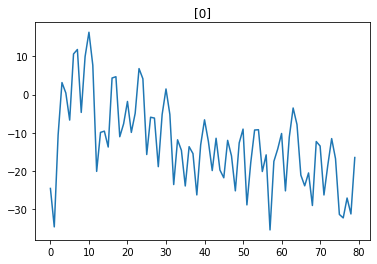

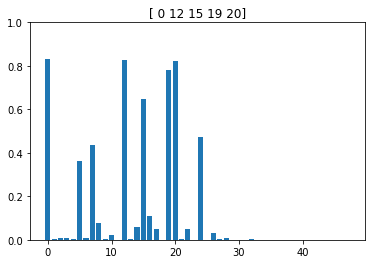

Predicted: 4
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


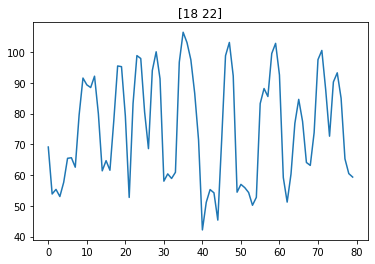

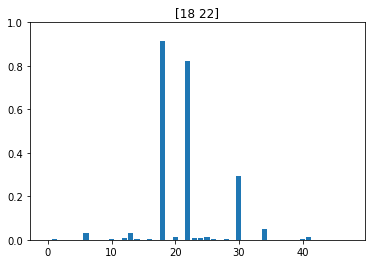

Predicted: 5
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


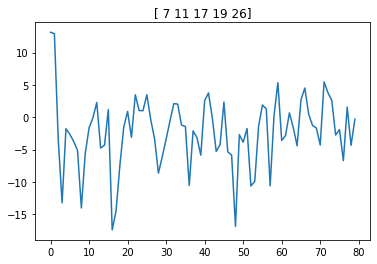

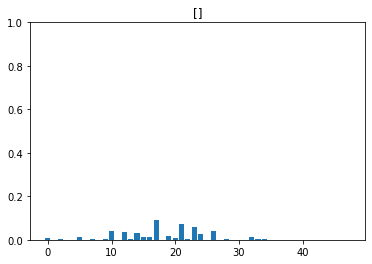

Predicted: 6
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


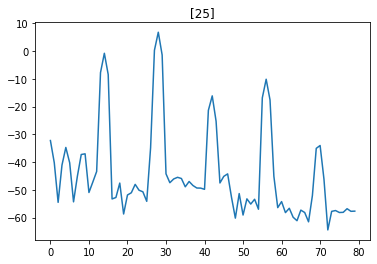

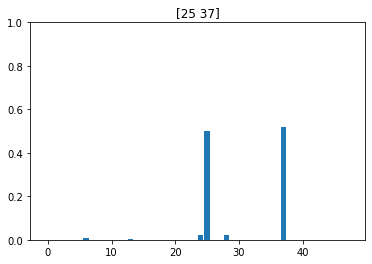

Predicted: 7
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


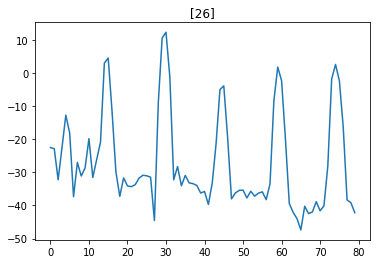

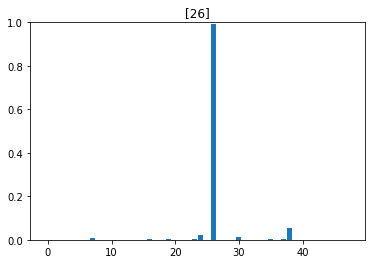

Predicted: 8
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


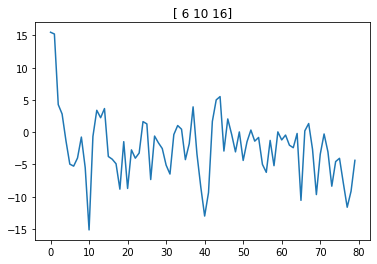

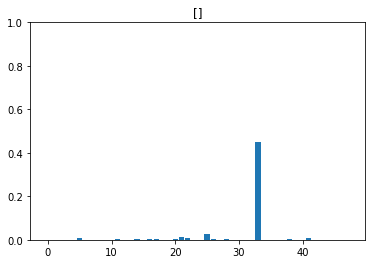

Predicted: 9
/home/oren/Projects/MidiOrDie/signature_extraction_model/venv3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


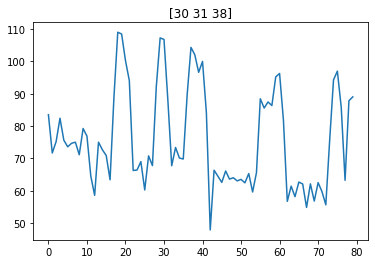

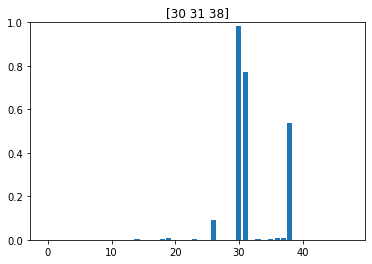

575
Predicted: 1576
Predicted: 1577
Predicted: 1578
Predicted: 1579
Predicted: 1580
Predicted: 1581
Predicted: 1582
Predicted: 1583
Predicted: 1584
Predicted: 1585
Predicted: 1586
Predicted: 1587
Predicted: 1588
Predicted: 1589
Predicted: 1590
Predicted: 1591
Predicted: 1592
Predicted: 1593
Predicted: 1594
Predicted: 1595
Predicted: 1596
Predicted: 1597
Predicted: 1598
Predicted: 1599
Predicted: 1600
Predicted: 1601
Predicted: 1602
Predicted: 1603
Predicted: 1604
Predicted: 1605
Predicted: 1606
Predicted: 1607
Predicted: 1608
Predicted: 1609
Predicted: 1610
Predicted: 1611
Predicted: 1612
Predicted: 1613
Predicted: 1614
Predicted: 1615
Predicted: 1616
Predicted: 1617
Predicted: 1618
Predicted: 1619
Predicted: 1620
Predicted: 1621
Predicted: 1622
Predicted: 1623
Predicted: 1624
Predicted: 1625
Predicted: 1626
Predicted: 1627
Predicted: 1628
Predicted: 1629
Predicted: 1630
Predicted: 1631
Predicted: 1632
Predicted: 1633
Predicted: 1634
Predicted: 1635
Predicted: 1636
Predicted: 1637
Pred

In [95]:
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
import time

model.load_weights("training_1/cp-0014.ckpt")

guesses = 0
false_positives = 0
total_labels = 0
false_negatives = 0
i = 0
for l, f in zip(labels_test, frames_test):
    before = time.time()
    inputs = np.expand_dims(f[0,:], axis=0)
    calibs = np.expand_dims(f[1:,:], axis=0)
    p = model.predict(inputs)[0]
    print("Predicted: " + str(i))
    #print("Time: %f" % (time.time() - before))

    # func = K.function([model.layers[5].input, model.layers[0].input], model.layers[9].output)
    # dot_out = func([calibs, inputs])

    conf = max(p)
    pred = np.where(p > 0.5)[0]
    if len(pred) > 6:
        # If more than 6, keep more probable ones
        pred_conf = list(zip(pred, [p[i] for i in pred]))
        pred_conf.sort(reverse=True, key=lambda x: x[1])
        pred = [x[0] for x in pred_conf[:6]]
    correct = np.where(l == 1)[0]
    # if len(correct) > 1:
    #     continue

    false_positives += len([x for x in pred if x not in correct])
    false_negatives += len([x for x in correct if x not in pred])
    guesses += len(pred)
    total_labels += len(correct)

    if i < 10:
        plt.plot(inputs[0,:])
        plt.title(correct)
        plt.show()
        # plt.plot(np.transpose(calibs[0]))
        # plt.show()
        plt.bar(np.arange(len(p)), p)
        plt.title(pred)
        plt.ylim((0,1))
        plt.show()
    i+=1

print("Detection rate: " + str(1 - false_negatives / total_labels))
print("False positive rate: " + str(false_positives / guesses))

In [96]:
print("Detection rate: " + str(1 - false_negatives / total_labels))
print("False positive rate: " + str(false_positives / guesses))

#model.save("tf_model")
model.summary()

Detection rate: 0.6611656569876749
False positive rate: 0.22312223858615612
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 80)]              0         
_________________________________________________________________
layer_normalization_47 (Laye (None, 80)                160       
_________________________________________________________________
dense_64 (Dense)             (None, 96)                7776      
_________________________________________________________________
dense_65 (Dense)             (None, 72)                6984      
_________________________________________________________________
dense_66 (Dense)             (None, 48)                3504      
Total params: 18,424
Trainable params: 18,424
Non-trainable params: 0
_________________________________________________________________
